# Homework 10

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Sunday, November 18th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns

import sklearn.model_selection

import pymc3 as pm
from pymc3 import Model, Normal, HalfNormal
import time

%matplotlib inline

## Question 1: Metropoflix and Chill (What's your Net Worth)?

**coding required**

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you may not recall the correct order, but the mistakes you make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *The Godfather: Part II*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *The Godfather: Part II*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Unfortunately, your answer is wrong.  Fortunately (for our purposes) we have a way of quantifying just how wrong. Define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is an indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}$$
where $\lambda$ can be thought of as an inverse temperature

1.1. Implement a Metropolis sampler to produce sample guesses from 500 individuals, with the $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

1.2. Compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) by the Metropolis algorithm sampler. Compare the resulting probabilities for the various $\lambda$ values. 

1.3. How does $\lambda$ affect the probability that *The Shawshank Redemption* is ranked as the top movie?


> 1.1. Implement a Metropolis sampler to produce sample guesses from 500 individuals, with the $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

In [2]:
def hamming(theta, omega):
    """
    Hamming distance
    """
    return np.not_equal(theta, omega).sum()


def q(theta):
    """
    Proposal distribution.
    """
    indices = np.random.choice(np.arange(0, 5), replace=False, size=2)
    theta_ = theta.copy()
    theta_[indices[0]] = theta[indices[1]]
    theta_[indices[1]] = theta[indices[0]]
    return theta_
    return np.random.choice(np.arange(1, 6), replace=False, size=5)

def p(theta, lambda_):
    """
    Probability of theta
    """
    omega = np.arange(1, 6)
    return np.exp(-lambda_*hamming(theta, omega))

def metropolis(n_samples, lambda_, x_init=np.array([1, 3, 2, 4, 5])):
    """
    Metropolis sampling algorithm
    """
    samples = np.empty((n_samples, 5))
    samples[0, :] = x_init
    x = x_init
    for i in range(n_samples):
        prop = q(x)
        #print(x, prop)
        prop_ratio = np.log(p(prop, lambda_)) - np.log(p(x, lambda_))
        if np.log(np.random.rand()) < prop_ratio:
            x = prop
        samples[i, :] = x
        
    return samples

In [3]:
for lambda_ in [0.2, 0.5, 1.0]:
    foo = metropolis(1000, lambda_)
    uniques, counts = np.unique(foo[500:, :], axis=0, return_counts=True)
    print("lambda =", lambda_)
    print("Top 5:", uniques[(-counts).argsort()[:5], :])
    print("And their counts: ", counts[(-counts).argsort()[:5]])
    print("*"*50)

lambda = 0.2
Top 5: [[1. 4. 3. 2. 5.]
 [5. 3. 4. 2. 1.]
 [3. 2. 1. 4. 5.]
 [2. 3. 1. 4. 5.]
 [5. 1. 2. 4. 3.]]
And their counts:  [13 11 10 10 10]
**************************************************
lambda = 0.5
Top 5: [[4. 2. 1. 3. 5.]
 [4. 2. 3. 1. 5.]
 [1. 2. 3. 4. 5.]
 [5. 2. 3. 4. 1.]
 [1. 2. 4. 3. 5.]]
And their counts:  [22 19 18 14 13]
**************************************************
lambda = 1.0
Top 5: [[1. 2. 3. 4. 5.]
 [1. 5. 3. 4. 2.]
 [4. 2. 3. 1. 5.]
 [1. 2. 5. 4. 3.]
 [1. 5. 2. 4. 3.]]
And their counts:  [112  28  20  18  17]
**************************************************


> 1.2. Compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) by the Metropolis algorithm sampler. Compare the resulting probabilities for the various $\lambda$ values. 

In [4]:
for lambda_ in [0.2, 0.5, 1.0]:
    foo = metropolis(1000, lambda_)
    print("lambda =", lambda_)
    prob_first_right = (foo[:, 0] == 1).mean()
    print("Probability that 'The Shawshank Redemption comes first: {:.3f}".format(prob_first_right))
    print("*"*50)

lambda = 0.2
Probability that 'The Shawshank Redemption comes first: 0.201
**************************************************
lambda = 0.5
Probability that 'The Shawshank Redemption comes first: 0.293
**************************************************
lambda = 1.0
Probability that 'The Shawshank Redemption comes first: 0.513
**************************************************


> 1.3. How does $\lambda$ affect the probability that *The Shawshank Redemption* is ranked as the top movie?

The probability seems to be increasing with $\lambda$. This makes sense thinking of $\lambda$ as an inverse temperature. The lower the temperature, i.e. the higher $\lambda$, the more we should be near the lowest energy state. The lowest energy states, ranking as many movies correct as possible, in particular rank the first movie correct.

**Gratuitous Titular Reference**:  

It's 2018 -- Even Wikipedia knows what [Netflix and Chill](https://en.wikipedia.org/wiki/Netflix_and_chill) is about. (mixtape by Grime MC Merky ACE].  

[Drake's the type of dude](https://knowyourmeme.com/memes/drake-the-type-of) to not care about [netflix and chill but about that net net net worth](https://youtu.be/DRS_PpOrUZ4?t=224) 

Drake may wanna know if [Kiki/KB](https://www.thefader.com/2018/10/24/real-kiki-drake-in-my-feelings-interview-kyanna-barber) is feeling him, but the [NTSB](https://www.ntsb.gov)  [definitely isn't](https://www.cnn.com/2018/07/25/entertainment/ntsb-in-my-feelings/index.html)

Shout out [Nawlins](https://riverbeats.life/neworleans/drake-shares-his-in-my-feelings) and [Atlanta](http://www.thefader.com/2018/06/29/drake-sampled-atlanta-scorpion).

<div class="answer-separator">
------------------------
</div>

## Question 2: In a Flash the Iris devient un Fleur-de-Lis.

**coding required**

We've done classification before, but the goal of this problem is to introduce you to the idea of classification using Bayesian inference. 

Consider the famous *Fisher flower Iris data set* a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis. The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoe90cwt3dla%2Firis.csv).

Let $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is the standard feature vector corresponding to an offset 1 and the four components explained above. $Y \in \{0,1\}$ are the scalar labels of a class. In other words the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features -- petal length, petal width, sepal length and sepal width -- along with the offset make up your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Note: You might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).


2.1. Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. (Feel free to take advantage of scikit-learn's `train_test_split`).

2.2. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.

2.3. Find the MAP for the posterior on the training set.

2.4. Implement a PyMC3 model to sample from this posterior of $\beta$.  

2.5. Generate 5000 samples of $\beta$.  Visualize the betas and generate a traceplot and autocorrelation plots for each beta component.

2.6. Based on your samples construct an estimate for the posterior mean.

2.7. Select at least 2 datapoints and visualize a histogram of the posterior probabilities.  Denote the posterior mean and MAP on your plot for each datapoint


Although having the posterior probabilities is nice, they are not enough.  We need to think about how to make predictions based on our machinery.  If we define the following:

 - $p_{MEAN}$: using the posterior mean betas to generate probabilities for each data point
 - $p_{MAP}$: using the posterior MAP betas to generate probabilities for each data point
 - $p_{CDF}$: using the fraction of your posterior samples have values above 0.5 for each data point
 - $p_{PP}$:  using the fraction of 1s out of the samples drawn from the posterior predictive distribution for each data point

2.8. Plot the distributions of $p_{MEAN}$, $p_{CDF}$, $p_{MAP}$ and $p_{PP}$ over all the data points in the training set. How are these different?


How do we turn these probabilities into predictions?  *There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

- Sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

- Do the intuitive "machine-learning-decision-theoretic" (MLDT) thing and you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

2.9. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.

2.10. For every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Using the MLDT defined above, overlay a plot of the histogram of the misclassification rate for the posterior on the corresponding plot for the posterior-predictive you constructed in 2.9.  Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 

2.11. Repeat 2.9 and 2.10 for the test set (i.e. make predictions).  Describe and interpret the widths of the resulting distributions.

> 2.1. Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. (Feel free to take advantage of scikit-learn's `train_test_split`).

We start by reading in the data and reclassifind all Non-virginicas.

In [5]:
iris = pd.read_csv("https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoe90cwt3dla%2Firis.csv")

iris['Intercept'] = 1
iris.loc[iris['class'] != " Iris-setosa", "class"] = "Not-virginica"
labels = np.zeros(iris.shape[0])
labels[iris['class'] == "Not-virginica"] = 1

iris['class'].value_counts()


Not-virginica    100
 Iris-setosa      50
Name: class, dtype: int64

Next, we do the train-test-split.

In [6]:
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(iris, labels, stratify=iris['class'], test_size=0.4,
                                                                                 random_state=0)

In [7]:
train_labels.shape

(90,)

> 2.2. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.

$$
p(\beta \vert Y, X) = p(Y \vert X, \beta) p(\beta) \propto \\
\propto \prod_i \left(\frac{1}{1 + e^{-\beta^T x_i}}\right)^{y_i} \left(1 -  \frac{1}{1 + e^{-\beta^T x_i}}\right)^{1 - y_i} \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\lVert\beta^2\rVert/(2\sigma^2)}
$$

There's no closed form solution to this equation and we have to do some kind of numerical optimization.

> 2.3. Find the MAP for the posterior on the training set.

In [8]:
x = train[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'Intercept']].values

In [9]:
from theano import shared
x_shared = shared(x)

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sd=10, shape=5)
    logits = pm.math.dot(x_shared, beta)
    p = pm.Deterministic('p', pm.math.invlogit(logits))
    obs_class = pm.distributions.discrete.Bernoulli('obs_class', logit_p=logits, observed=train_labels)
    
map_estimate = pm.find_MAP(model=model)
map_estimate['beta']

logp = -16.334, ||grad|| = 0.0028943: 100%|██████████| 26/26 [00:00<00:00, 1423.86it/s]  


array([-0.97823714, -2.75714522,  4.61933424,  1.91952672, -0.56245344])

We compare with `sklearn` and `C=100` (corresponding to $\sigma=10$).

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs', fit_intercept=False,
                        C=100).fit(x, train_labels)

clf.coef_

array([[-0.97852102, -2.7570461 ,  4.61963796,  1.92007172, -0.56225165]])

Looks good.

> 2.4. Implement a PyMC3 model to sample from this posterior of $\beta$.  
> 2.5. Generate 5000 samples of $\beta$.  Visualize the betas and generate a traceplot and autocorrelation plots for each beta component.

In [11]:
with model:
    # instantiate sampler
    step = pm.HamiltonianMC()
    
    # draw 2000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [beta]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:12<00:00, 575.31draws/s]
There were 433 divergences after tuning. Increase `target_accept` or reparameterize.
There were 577 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


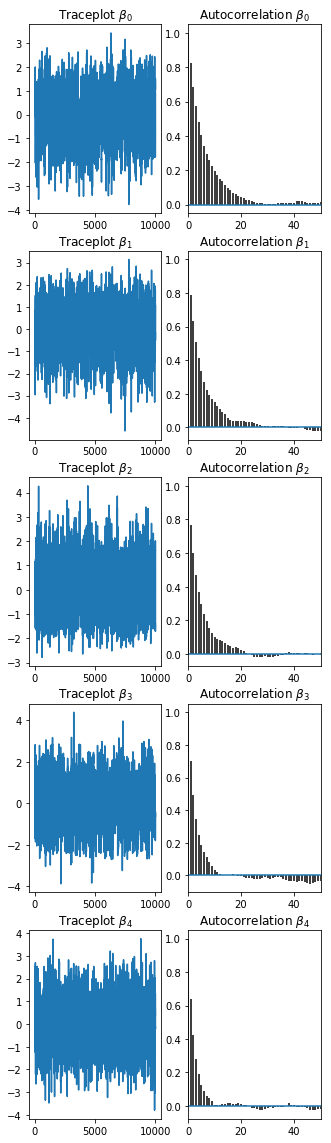

In [12]:

def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

betas = trace['beta']
for k in range(5):
    beta_norm = betas[:, k]
    beta_norm = (beta_norm - beta_norm.mean()) / beta_norm.std()
    ax = plt.subplot(5, 2, 2*k + 1)
    ax.set_title(r"Traceplot $\beta_{}$".format(k))
    plt.plot(beta_norm)
    ax = plt.subplot(5, 2, 2*k + 2)
    corrplot(beta_norm)
    ax.set_title(r"Autocorrelation $\beta_{}$".format(k))
    
plt.subplots_adjust(bottom=0.2, right=0.8, top=4)

Let's also visualize the correlations:

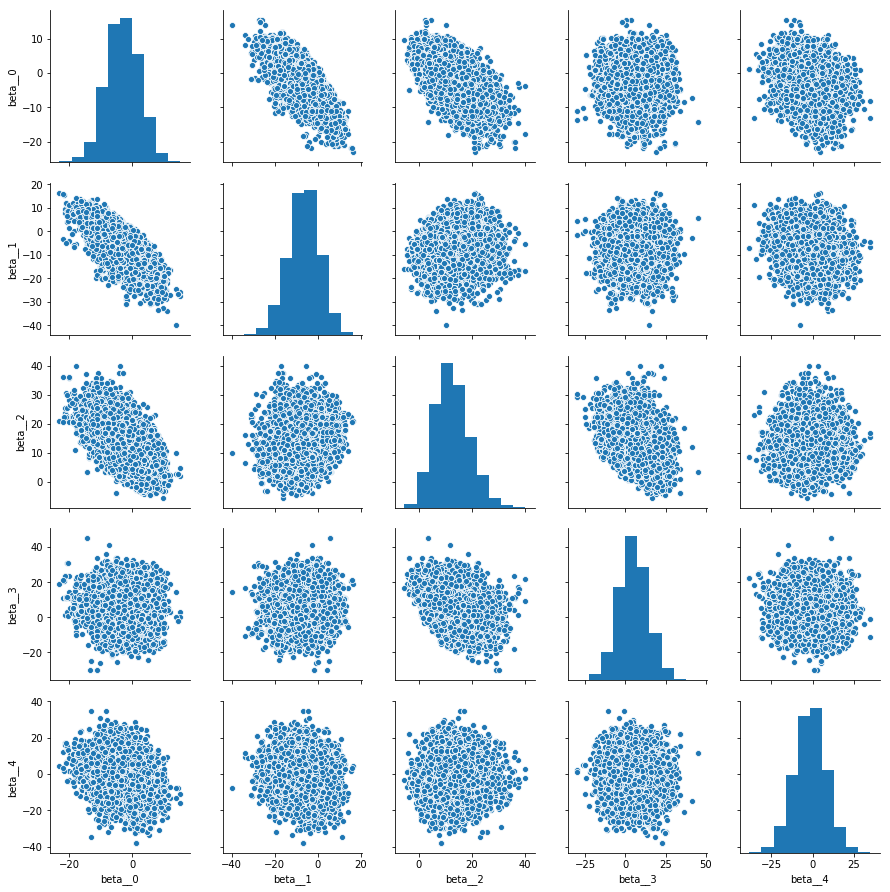

In [13]:
tracedf1 = pm.trace_to_dataframe(trace)[['beta__' + str(i) for i in range(5)]]
sns.pairplot(tracedf1);

> 2.6. Based on your samples construct an estimate for the posterior mean.

In [14]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-2.969817,5.323611,1.652726e-01,-1.316576e+01,7.225032,802.960280,1.004430
beta__1,-6.554989,7.265437,2.003255e-01,-2.069393e+01,7.711592,951.875070,1.004379
beta__2,12.499934,6.440526,1.774968e-01,1.212804e+00,25.588987,1128.787844,1.001202
beta__3,5.110572,9.127295,1.869746e-01,-1.293101e+01,23.430963,1701.669939,1.000003
beta__4,-1.463637,9.625786,2.003094e-01,-2.017474e+01,17.279067,2029.433133,0.999913
p__0,0.998329,0.017615,3.304130e-04,9.989370e-01,1.000000,3159.941906,1.001127
p__1,0.999469,0.003124,6.171934e-05,9.982082e-01,1.000000,2536.870410,0.999908
p__2,0.999122,0.007104,1.299375e-04,9.978789e-01,1.000000,2698.943386,0.999964
p__3,0.000241,0.001917,4.460185e-05,2.220446e-16,0.000544,1338.276916,1.001549
p__4,0.999996,0.000056,1.067543e-06,9.999995e-01,1.000000,2752.909895,1.000036


> 2.7. Select at least 2 datapoints and visualize a histogram of the posterior probabilities.  Denote the posterior mean and MAP on your plot for each datapoint

Let's select one datapoint from each class. The first is not-setosa while the last one is setosa. We show both in one plot for easier comparison.

In [15]:
train_labels[[0, -1]]

array([1., 0.])

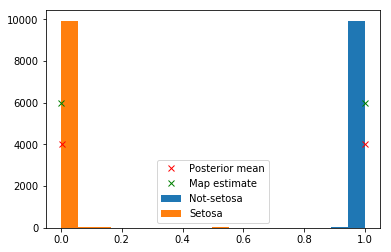

In [16]:
chosen_points = [0, 89]
map_points = scipy.special.expit(np.dot(x[chosen_points, :], map_estimate['beta']))

plt.hist(trace['p'][:, chosen_points[0]], label='Not-setosa')
plt.hist(trace['p'][:, chosen_points[1]], label='Setosa')
plt.plot(trace['p'].mean(axis=0)[chosen_points], [4000, 4000], 'rx', label='Posterior mean')
plt.plot(map_points, [6000, 6000], 'gx', label='Map estimate')

plt.legend()

We see clearly that the distribution are very concentrated near their respectively correct classes.

> Although having the posterior probabilities is nice, they are not enough.  We need to think about how to make predictions based on our machinery.  If we define the following:

> - $p_{MEAN}$: using the posterior mean betas to generate probabilities for each data point
 - $p_{MAP}$: using the posterior MAP betas to generate probabilities for each data point
 - $p_{CDF}$: using the fraction of your posterior samples have values above 0.5 for each data point
 - $p_{PP}$:  using the fraction of 1s out of the samples drawn from the posterior predictive distribution for each data point

> 2.8. Plot the distributions of $p_{MEAN}$, $p_{CDF}$, $p_{MAP}$ and $p_{PP}$ over all the data points in the training set. How are these different?

In [17]:
with model:
    sim = pm.sample_ppc(trace, samples=5000)

100%|██████████| 5000/5000 [00:03<00:00, 1510.82it/s]


In [18]:
p_mean = trace['p'].mean(axis=0)
p_map = map_estimate['p']
p_cdf = (trace['p'] > 0.5).mean(axis=0)
p_pp = (sim['obs_class'] == 1).mean(axis=0)

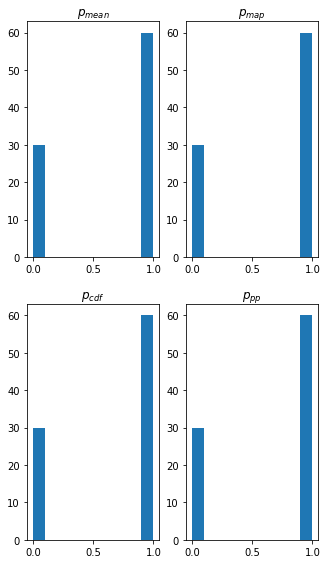

In [19]:
ax = plt.subplot(2, 2, 1)
ax.set_title(r"$p_{mean}$")
plt.hist(p_mean)

ax = plt.subplot(2, 2, 2)
ax.set_title(r"$p_{map}$")
plt.hist(p_map)

ax = plt.subplot(2, 2, 3)
ax.set_title(r"$p_{cdf}$")
plt.hist(p_cdf)

ax = plt.subplot(2, 2, 4)
ax.set_title(r"$p_{pp}$")
plt.hist(p_pp)
plt.subplots_adjust(bottom=0.2, right=0.8, top=2)

Look pretty much identical!

> 2.9. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.

(array([4.471e+03, 4.140e+02, 7.900e+01, 0.000e+00, 2.800e+01, 4.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.00777778, 0.01555556, 0.02333333, 0.03111111,
        0.03888889, 0.04666667, 0.05444444, 0.06222222, 0.07      ,
        0.07777778]),
 <a list of 10 Patch objects>)

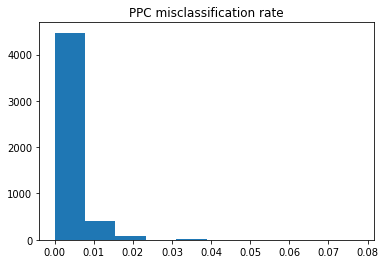

In [20]:
misclassification_by_samples = train_labels * (1 - sim['obs_class']) + (1 - train_labels) * sim['obs_class']
misclassification_rate = misclassification_by_samples.mean(axis=1)
plt.title("PPC misclassification rate")
plt.hist(misclassification_rate)

We can also calcualte a misclassification rate using the trace probabilities (which should contain less sampling variance than with PPC):

(array([8.775e+03, 6.850e+02, 2.750e+02, 1.400e+02, 5.300e+01, 3.200e+01,
        1.100e+01, 5.000e+00, 0.000e+00, 2.400e+01]),
 array([2.22053449e-16, 3.79624425e-03, 7.59248850e-03, 1.13887327e-02,
        1.51849770e-02, 1.89812212e-02, 2.27774655e-02, 2.65737097e-02,
        3.03699540e-02, 3.41661982e-02, 3.79624425e-02]),
 <a list of 10 Patch objects>)

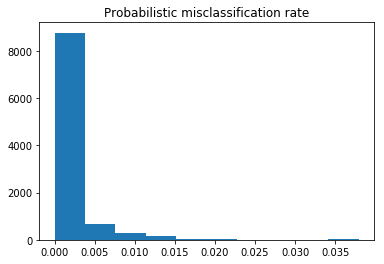

In [21]:
misclassification_by_samples = train_labels * (1 - trace['p']) + (1 - train_labels) * trace['p']
misclassification_rate = misclassification_by_samples.mean(axis=1)
plt.title("Probabilistic misclassification rate")
plt.hist(misclassification_rate)

> 2.10. For every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Using the MLDT defined above, overlay a plot of the histogram of the misclassification rate for the posterior on the corresponding plot for the posterior-predictive you constructed in 2.9.  Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 

Text(0.5, 1.0, 'Decision-theoretic misclassification rate')

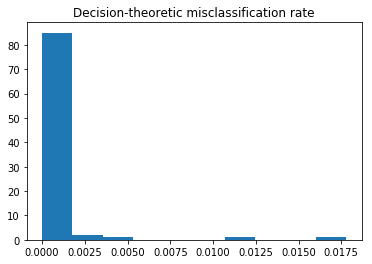

In [22]:
preds = trace['p'] > 0.5
mcr = (preds != train_labels)
plt.hist(mcr.mean(axis=0))
plt.title("Decision-theoretic misclassification rate")

We're almost always correct. Maximal misclassification rate is around 2%.

The misclassification rate from 2.9 is wider. The reason is that the probability of misclassification using the decision theoretic perspective is much smaller in 2.10. In 2.9, we accumulate lots of small errors.

> 2.11. Repeat 2.9 and 2.10 for the test set (i.e. make predictions).  Describe and interpret the widths of the resulting distributions.

In [23]:
x_test = test[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'Intercept']].values
p = scipy.special.expit(np.dot(trace['beta'], x_test.transpose()))

In [24]:
x_shared.set_value(x_test)
with model:
    sim = pm.sample_ppc(trace, samples=5000)

100%|██████████| 5000/5000 [00:03<00:00, 1305.57it/s]


(array([4.077e+03, 6.270e+02, 0.000e+00, 2.150e+02, 0.000e+00, 5.900e+01,
        1.900e+01, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 <a list of 10 Patch objects>)

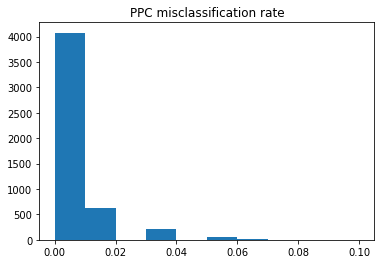

In [25]:
misclassification_by_samples = test_labels * (1 - sim['obs_class']) + (1 - test_labels) * sim['obs_class']
misclassification_rate = misclassification_by_samples.mean(axis=1)
plt.title("PPC misclassification rate")
plt.hist(misclassification_rate)

(array([8.038e+03, 7.730e+02, 5.500e+02, 2.860e+02, 1.830e+02, 1.020e+02,
        4.700e+01, 1.100e+01, 5.000e+00, 5.000e+00]),
 array([4.55881469e-15, 7.21748950e-03, 1.44349790e-02, 2.16524685e-02,
        2.88699580e-02, 3.60874475e-02, 4.33049370e-02, 5.05224265e-02,
        5.77399160e-02, 6.49574055e-02, 7.21748950e-02]),
 <a list of 10 Patch objects>)

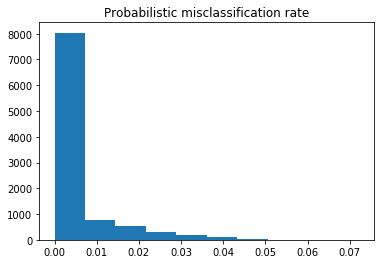

In [26]:
misclassification_by_samples = test_labels * (1 - p) + (1 - test_labels) * p
misclassification_rate = misclassification_by_samples.mean(axis=1)
plt.title("Probabilistic misclassification rate")
plt.hist(misclassification_rate)

Text(0.5, 1.0, 'Decision-theoretic Misclassification rate')

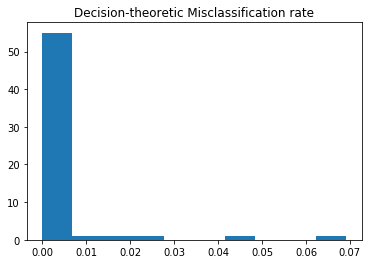

In [27]:
preds = p > 0.5
mcr = (preds != test_labels)
plt.hist(mcr.mean(axis=0))
plt.title("Decision-theoretic Misclassification rate")

We see that the misclassification rate is higher than on the training set, which is to be expected. And again, the probabilistic misclassification rate (from 2.9) is higher than the decision-theoretic one.

**Gratuitous Titular References**:  

[The Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) was introduced by Ronald Fisher as part of a [famous article](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1469-1809.1936.tb02137.x) introducing [LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis).

The three iris variants in the dataset were at the time [difficult to tell apart morphologically](https://www.jstor.org/stable/2394164?seq=1#page_scan_tab_contents)

While the origin of the [Fleur-de-Lis is debated](https://www.heraldica.org/topics/fdl.htm), it is most likely an [Iris florentina](https://en.wikipedia.org/wiki/Iris_florentina) or [Iris pseudacorus](https://en.wikipedia.org/wiki/Iris_pseudacorus) but not a [lily flower](https://www.collinsdictionary.com/dictionary/english-french/lily).

[Iris West](https://en.wikipedia.org/wiki/Iris_West) is a love interest of [Barry Allen](https://en.wikipedia.org/wiki/Flash_(Barry_Allen) one of the main incarnations of [The Flash](https://en.wikipedia.org/wiki/Flash_(comics).  Coming from [Central City](https://en.wikipedia.org/wiki/Central_City_(DC_Comics) she is most likely classified as **not-virginica**.

<div class="answer-separator">
------------------------
</div>

## Question 3 - Our Yelp Restaurant Review is in and the Fish is So Raw!

**no coding required**

In this course, we've spent a lot of time learning algorithms for performing inference on complex models. We've also spent time using these models to make decisions regarding our data. But in nearly every assignment, the model for the data is specified in the problem statement. In real life, the creative and, arguably, much more difficult task is to start with a broadly defined goal and then to customize or create a model which will meet this goal in some way. 


This homework problem is atypical in that it does not involve any programming or (necessarily) difficult mathematics/statistics. The process of answering these questions *seriously* will however give you an idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model if and when you're called upon to do so.

***Grading:*** *We want you to make a genuine effort to mold an ambiguous and broad real-life question into a concrete data science or machine learning problem without the pressure of getting the "right answer". As such, we will grade your answer to this homework question on a pass/fail basis. Any reasonable answer that demonstrates actual effort will be given a full grade.*

We've compiled for you a fairly representative selection of [Yelp reviews](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoe92vh7ni6e%2Fyelp_reviews.zip for a (now closed) sushi restaurant called Ino's Sushi in San Francisco. Read the reviews and form an opinion regarding the various qualities of Ino's Sushi. Answer the following:

3.1. If the task is to summarize the quality of a restaurant in a simple and intuitive way, what might be problematic with simply classifying this restaurant as simply "good" or "bad"? Justify your answers with specific examples from the dataset.

3.2. For Ino's Sushi, categorize the food and the service, separately, as "good" or "bad" based on all the reviews in the dataset. Be as systematic as you can when you do this.

  (**Hint:** Begin by summarizing each review. For each review, summarize the reviewer's opinion on two aspects of the restaurant: food and service. That is, generate a classification ("good" or "bad") for each aspect based on what the reviewer writes.) 
  
3.3. Identify statistical weaknesses in breaking each review down into an opinion on the food and an opinion on the service. That is, identify types of reviews that make your method of summarizing the reviewer's optinion on the quality of food and service problemmatic, if not impossible. Use examples from your dataset to support your argument. 

3.4. Identify all the ways in which the task in 3.2 might be difficult for a machine to accomplish. That is, break down the classification task into simple self-contained subtasks and identify how each subtask can be accomplished by a machine (i.e. which area of machine learning, e.g. topic modeling, sentiment analysis etc, addressess this type of task).

3.5. Now let us think of a different problem, a regression problem in which our aim is to predict and do inference on what rating a given user of Yelp might give a particular restaurant. How might you estimate the across-user quality of a restaurant from data? And how might you estimate the across-restaurant curmudgeonlyness of a user?

3.6 Additionally, consider a "space of latent factors" where aspects of the user's taste interact with aspects of the restaurant. An example of such a factor might be the user's propensity to get emotional after having the perfect filet-mignon. How might you combine this information with that in 3.5 to improve your prediction and inference?

> 3.1. If the task is to summarize the quality of a restaurant in a simple and intuitive way, what might be problematic with simply classifying this restaurant as simply "good" or "bad"? Justify your answers with specific examples from the dataset.

There are several things that can be wrong with simply summarizing a restaurant as "good" or "bad".

1. A restaurant can be "good" or "bad" in several different ways, i.e. there are different dimensions of quality. A concerete example encountered in the dataset is the `review02.png`. "Service can make you feel uncomfortable[...]", "the sushi was...amazing". We see that a restaurant can be judged bad in service, but good in quality of food.
2. If a restaurant gets mostly 5 star and 1 star reviews (as the one from the dataset), this is different than a restaurant getting mostly 3 or 4 star reviews. Simply classifing it as "good" or "bad" can't do justice to such a distinction.

> 3.2. For Ino's Sushi, categorize the food and the service, separately, as "good" or "bad" based on all the reviews in the dataset. Be as systematic as you can when you do this.

>  (**Hint:** Begin by summarizing each review. For each review, summarize the reviewer's opinion on two aspects of the restaurant: food and service. That is, generate a classification ("good" or "bad") for each aspect based on what the reviewer writes.) 

We can compile a dataframe by manually compiling a dataframe:

In [28]:
foo = [{'review': 'review01.png', 'service': 'bad', 'food': 'good'},
       {'review': 'review02.png', 'service': 'bad', 'food': 'good'},
       {'review': 'review03.png', 'service': 'bad'},
       {'review': 'review04.png', 'service': 'bad', 'food': 'good'},
       {'review': 'review05.png', 'food': 'good'},
       {'review': 'review06.png', 'food': 'good'},
       {'review': 'review07.png', 'service': 'good', 'food': 'good'},
       {'review': 'review08.png', 'food': 'good'},
       {'review': 'review09.png', 'service': 'bad'},
       {'review': 'review10.png', 'service': 'good', 'food': 'good'}]

In [29]:
pd.DataFrame(foo)

,food,review,service
0,good,review01.png,bad
1,good,review02.png,bad
2,NaN,review03.png,bad
3,good,review04.png,bad
4,good,review05.png,NaN
5,good,review06.png,NaN
6,good,review07.png,good
7,good,review08.png,NaN
8,NaN,review09.png,bad
9,good,review10.png,good


> 3.3. Identify statistical weaknesses in breaking each review down into an opinion on the food and an opinion on the service. That is, identify types of reviews that make your method of summarizing the reviewer's optinion on the quality of food and service problemmatic, if not impossible. Use examples from your dataset to support your argument. 

Some reviews only contain a rating on the food while other contain only a rating on the quality of service (e.g. `review09.png`: "this review is NOT on their food since I barely got a chance to sit down and got kicked out - literally"). This might not be the most serious problem, but it reduces the amount of data we have.

Secondly, it's not always clear that you can rate the food or service as "good" or "bad". There are some mediocore reviews.

Since we are reading the text to extract two separate quantities, we also cannot use the star-rating as guidance there, since there are examples that have excellent quality of food, but poor quality of service, but still give five stars (see `review02.png`, for example).

Next, labelling a review as "good" or "bad" and splitting into quality of food and service is not unambiguous. After all, someone needs to put in the work of labelling the data and if we want to have a reasonable size of data, we will need several people to do that. So it's likely that we get some additional variation there.

> 3.4. Identify all the ways in which the task in 3.2 might be difficult for a machine to accomplish. That is, break down the classification task into simple self-contained subtasks and identify how each subtask can be accomplished by a machine (i.e. which area of machine learning, e.g. topic modeling, sentiment analysis etc, addressess this type of task).

The first task that we need to accomplish is to actually **label** the dataset. It's clear that we need a reasonably sized dataset (we'd guess 10'000+ reviews for simple models) to build any model at all. This is a cost-intensive task and we estimate a rough cost of one minute per review.

A statistical problem is that labelling reviews as "good" or "bad" is not clear cut. Depending on the requirements, labellers may disagree. For example, if we require that every review be labelled (i.e. we don't allow missing labels), then there is a high potential for ambiguities. Consider, for example `review04.png`: the reviewer gives one star, but claims that the sushi has high quality. If you only care about food, it's good, overall the experience for the customer was bad.
If we allow missing labels, the situation probably does not improve very much, as then labellers can only label the easy cases and assign missing to the rest.

After labelling, the next task is **text understanding**. To do that, we need to start with **feature extraction**, i.e. convert the text to something we can actually use. There are several things we can do at this stage:

+ Embed the text in vector spaces via counts (tf or tf-idf)
+ Embed the text in vector space with pre-trained model like word2vec or the embedding model on TensorHub

After that we can **fit any classifier** to predict the labels (using the standard ML techniques like cross-validation). It's actually important at this stage to know whether we only care about accuracy or also interpretability. If the former, we might actually simply use a neural network. If the latter, we might try an approach like doing topic modelling before and then build a classifier only on the topics (or use [supervised LDA](https://arxiv.org/pdf/1003.0783.pdf)).

Finally, we should try to get an understanding of the model quality, calculate accuracy etc. It's also useful to use an approach like [LIME](https://github.com/marcotcr/lime) to get a more intuitive understanding of the model.

> 3.5. Now let us think of a different problem, a regression problem in which our aim is to predict and do inference on what rating a given user of Yelp might give a particular restaurant. How might you estimate the across-user quality of a restaurant from data? And how might you estimate the across-restaurant curmudgeonlyness of a user?

The simplest and most naive approach to modelling the across-user quality of a restaurant from data is to use simple summary statistics like the sample mean over all users that rated the restaurant. This suffers from well known problems (reviews with few datapoints, for example). 

The simplest solution to that would be some kind of regularization, for example using hierarchical modelling to have a prior distribution of restaurant ratings with likelihood given by some distribution on the number of stars. 

Another problem that we can encounter is that users have different "behavior": for example, some users tend to rate 4 stars on average while others rate lower on average. Also, users can rate more extreme or more conservative. When classifying a restaurant, we should take the user behavior into account.

Similarly, when thinking about user rating, we should maybe consider what kinds of restaurant they evaluated. If they rated worse restaurants on average, then they might actually not be users who tend to rate restaurants worse. 

The two observations combined sound a bit like a chicken-and-egg problem, or like an EM problem, which leads us to think that we can use Bayesian stats to model the situation better.

Let's think about a possible data generating process. How does a rating come about? We have a user $i$ and a restaurant $j$ and this leads to a rating $r_{ij}$. $r_{ij}$ is an ordered variable. So, we are intereted in obtaining $p(R=r_{ij}\vert user=i, restaurant=j)$. Without any modelling assumption, we cannot compute this probability.

But the description above can guide the way. Let's suppose each user has a "bias" $\mu_i$ and a variability $\sigma_i$ and each resturant has a "quality" $q_j$. Then a rating should come from some likelihood, maybe

$$
R_{ij} \sim \mu_i + q_j + \epsilon(\sigma_i, \tau) \:.
$$

So, we have a user bias term, a quality term and some noise term the determines the likelihood. The noise term comes from how extreme the user rates the restaurants and some other noise (which could possibly depend on the restaurant as well, but let's start simple).

If we now specify distributions for each of the terms, we're actually in a situation where we can compute the posterior distribution. It's probably impossible to do that analytically and with any reasonably sized dataset, we also can't do MCMC. So in real life, we'd have to resort to other technique like variational inference or EM.

We see the beauty of Bayesian statistics in action here: we don't have to be constrained by what models are available, we can think of a plausible data generating process and then of the fitting later.

> 3.6 Additionally, consider a "space of latent factors" where aspects of the user's taste interact with aspects of the restaurant. An example of such a factor might be the user's propensity to get emotional after having the perfect filet-mignon. How might you combine this information with that in 3.5 to improve your prediction and inference?

After the previous answer it's pretty clear how we could such things. We could simply add any term we want to the equation above. Some latent factors are already captured by the model above, but we could add in new terms. For example, if we knew the time difference between the restaurant visit and the review, we can add in a user dependent term linear in the time dependence, etc.

With neural networks, for example, we could literally try to embed a user in a (high- or low-dimensional) space of "user latent factors" and do the same with restaurants. Then we can use these embeddings to calculate an answer.

**Gratuitous Titular Reference**:  

[Sushi is not raw fish](http://www.todayifoundout.com/index.php/2011/12/sushi-is-not-raw-fish)

![](https://i.imgflip.com/pnawi.jpg)

[More Gordon Ramsey memes](https://knowyourmeme.com/memes/people/gordon-ramsay)

<div class="answer-separator">
------------------------
</div>